# Задача

Для решения была выбрана задача кластеризации на датасете [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html).

### Разведочный анализ

В датасете содержатся картинки 32 на 32 пикселя с rgb цветом, которые принадлежат 10 различным классам.

Необходимо решить задачу кластеризации.

Подключим библиотеки

In [3]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings("ignore")

Считаем данные. Так как изначально данные - это картинки 32 на 32 с rgb цветом, преобразуем их к вектору длины 32 * 32 * 3 = 3076.

In [19]:
import os
import numpy as np
from PIL import Image

def convert_image_to_data_row(image_name):
    img = Image.open(image_name).convert('RGB')
    arr = np.array(img)

    flat_arr = arr.ravel()
    return flat_arr

labels_df = pd.read_csv('../data/cifar10/trainLabels.csv',
                                 sep=',',
                                 usecols=["id", "label"]
)
data_list = list()
for index, row in labels_df.iterrows():
    image_name = str(row['id']) + '.png'
    full_name = "../data/cifar10/train/" + image_name
    data_list.append(convert_image_to_data_row(full_name))

labels_df['data'] = data_list

In [20]:
print(labels_df.head())

   id       label                                               data
0   1        frog  [59, 62, 63, 43, 46, 45, 50, 48, 43, 68, 54, 4...
1   2       truck  [154, 177, 187, 126, 137, 136, 105, 104, 95, 1...
2   3       truck  [255, 255, 255, 253, 253, 253, 253, 253, 253, ...
3   4        deer  [28, 25, 10, 37, 34, 19, 38, 35, 20, 42, 37, 2...
4   5  automobile  [170, 180, 198, 168, 178, 196, 177, 185, 203, ...


Выведем имена всех кластеров данных

In [22]:
labels_df['label'].count()

50000

In [23]:
labels_df.groupby(['label'])['label'].count()

label
airplane      5000
automobile    5000
bird          5000
cat           5000
deer          5000
dog           5000
frog          5000
horse         5000
ship          5000
truck         5000
Name: label, dtype: int64

В каждом кластере содержится по 5000 картинок, а всего кластеров 10. Попробуем визуализировать данные с помощью PCA и t-SNE в двух измерениях

In [33]:
labels_as_list = list(set(labels_df['label']))
print(labels_as_list)

['dog', 'ship', 'deer', 'horse', 'frog', 'bird', 'airplane', 'truck', 'automobile', 'cat']


In [64]:
def plot_2d_projection(X_reduced, c):
    plt.figure(figsize=(12,10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=c, 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.colorbar()
    plt.title('cifar10 dataset');
    
default_c = list(map(lambda label: labels_as_list.index(label), list(labels_df['label'])))

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = np.array(data_list)
X_reduced = pca.fit_transform(X)

In [67]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE()
X_tsne_reduced = tsne.fit_transform(X)

CPU times: user 48min 3s, sys: 25 s, total: 48min 28s
Wall time: 14min 56s


Сначала визуализируем PCA

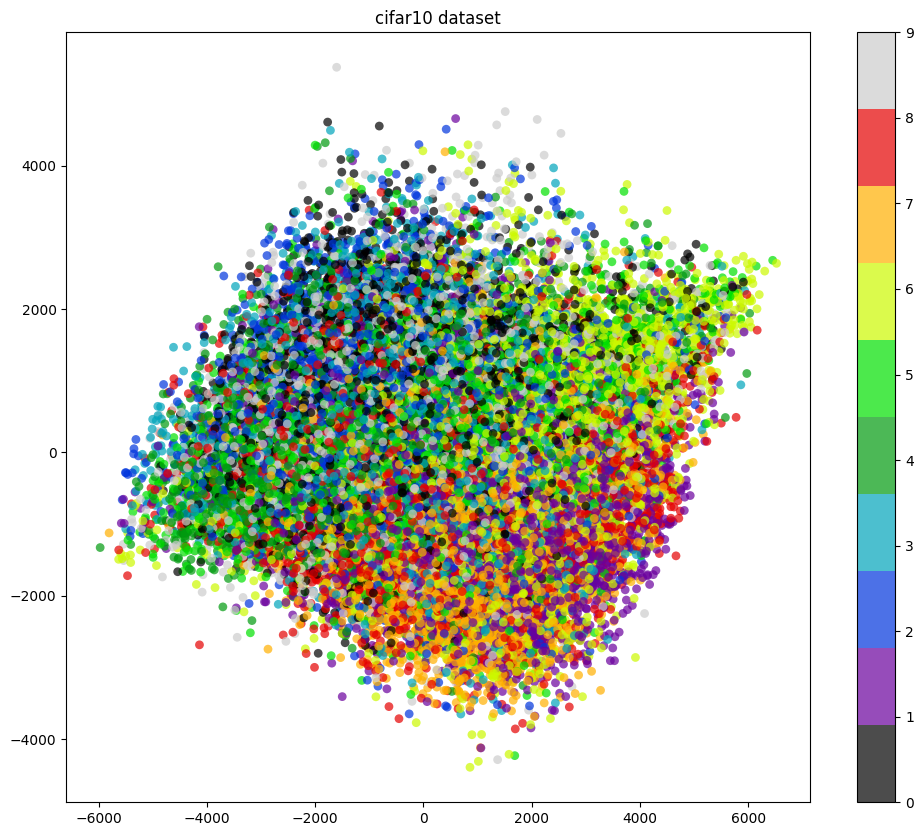

In [68]:
plot_2d_projection(X_reduced, default_c)

Затем t-SNE

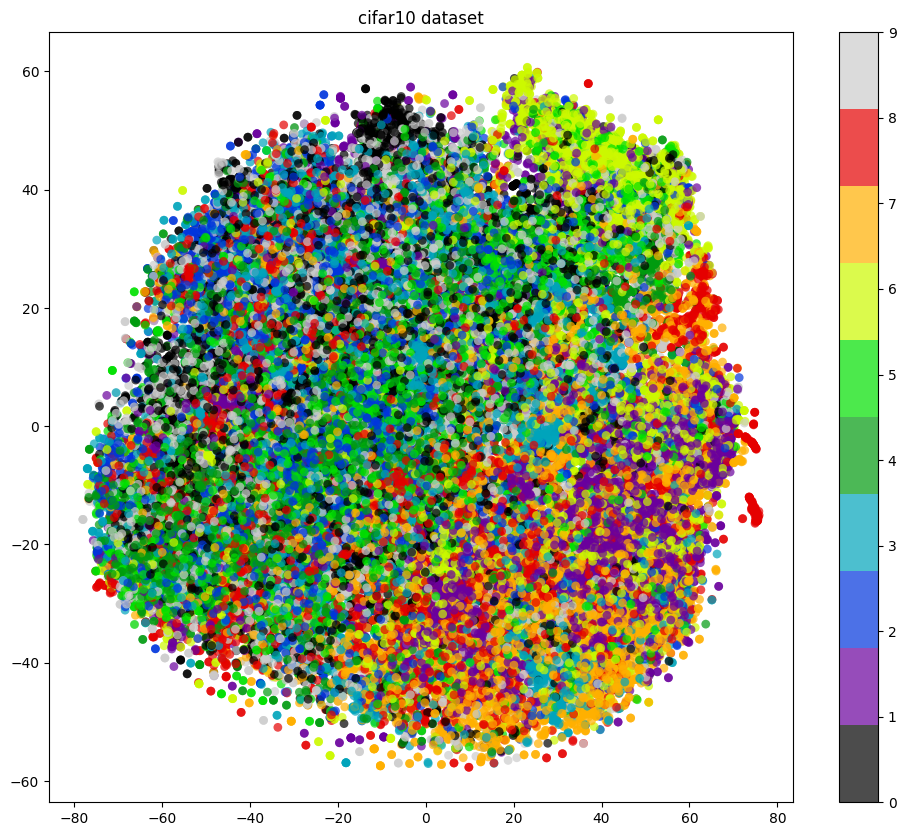

In [69]:
plot_2d_projection(X_tsne_reduced, default_c)

Видно, что при PCA с двумя измерениями данные кластеризуются плохо, как и при использовании t-SNE. Посмотрим, какое количество параметров содержит в себе наибольшую информацию

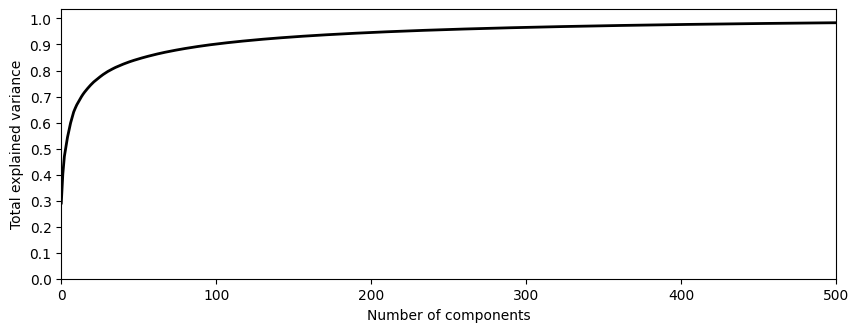

In [70]:
pca = PCA().fit(X)

plt.figure(figsize=(10,3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 500)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show();

Хорошо видно, что количество параметров можно попробовать снизить до 200-300, так как 300 параметров хорошо объясняют дисперсию.

### Обучение моделей

Перед тем как обучать модели, реализуем метод k-means

In [101]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted

class Task5KMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, tol=0.001):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = np.random.RandomState(seed=42)

    def predict(self, X):
        check_is_fitted(self)
        return self._clusterize(check_array(X))

    def fit(self, X):
        check_array(X)

        self.n_features_in_ = X.shape[1]
        self.cluster_centers_ = X[self.random_state.choice(len(X), size=self.n_clusters, replace=False)]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._clusterize(X)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in range(self.n_clusters):
                new[i] = np.mean(X[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))

            self.cluster_centers_ = new

        return self
    
    def _label_for_vector(self, vec):
        label = 0
        dist = np.linalg.norm(vec - self.cluster_centers_[0])
        for i in range(1, len(cluster_centers)):
            new_dist = np.linalg.norm(vec - self.cluster_centers_[i])
            if new_dist < dist:
                dist = new_dist
                label = i

        return label

    def _clusterize(self, X):
        return np.array(
            list(map(lambda vec: self._label_for_vector(vec), X))
        )

Напишем функцию для проведения замеров, а также уменьшим количество параметров с помощью PCA (поскольку 300 параметров объясняют 90% дисперсии изначальной выборки). В качестве метрики качества будем использовать [adjusted rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score).

In [71]:
X = np.array(data_list)
y = np.array(
    list(map(lambda label: labels_as_list.index(label), list(labels_df['label'])))
)
X_reduced_list = list()
for count in [100, 200, 300]:
    pca = PCA(n_components=count)
    X_reduced = pca.fit_transform(X)
    X_reduced_list.append((X_reduced, count))

In [104]:
from timeit import timeit
import itertools
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score

def time(stmt):
    return timeit(stmt=stmt, number=1)

def train_with_params(estimator, param_grid):
    param_combs = [
        dict(params) for params in
        itertools.product(
            *([(name, v) for v in vs] for (name, vs) in param_grid.items())
        )
    ]

    results = []
    for (X, count) in X_reduced_list:
        best_ars = -1 # real ars is great then -0,5
        best_params = {}
        best_fit_time = 0

        for params in param_combs:
            cloned_estimator = clone(estimator).set_params(**params)
            
            fit_time = time(lambda: cloned_estimator.fit(X))
            pred = cloned_estimator.fit_predict(X)

            ars = adjusted_rand_score(y, pred)
            if ars > best_ars:
                best_ars = ars
                best_params = params
                best_fit_time = fit_time


        print(
            f"Count of features: {count}:",
            f"Adjusted round score: {best_ars}",
            f"Best params: {str(best_params)}",
            "",
            sep="\n",
        )

        results.append(
            {
                "Clusterer": estimator.__class__.__name__,
                "Input dimension": count,
                "fit time, s": best_fit_time,
                "Adjusted round score": best_ars
            }
        )
        
    return pd.DataFrame(results)

Проведем замеры

In [105]:
%%time

task5kmeans_results = train_with_params(
    Task5KMeans(n_clusters=10),
    param_grid={
        # have no parameters in simple KMeans realisation
    },
)

Count of features: 100:
Adjusted round score: 0.023011572470288552
Best params: {}

Count of features: 200:
Adjusted round score: 0.022914853646903204
Best params: {}

Count of features: 300:
Adjusted round score: 0.022961979070225652
Best params: {}

CPU times: user 3.65 s, sys: 36.2 ms, total: 3.69 s
Wall time: 3.62 s


In [106]:
%%time
from sklearn.cluster import KMeans

kmeans_results = train_with_params(
    KMeans(n_clusters=10),
    param_grid={
        "algorithm": ["lloyd", "elkan"],
    },
)

Count of features: 100:
Adjusted round score: 0.0418675178829749
Best params: {'algorithm': 'lloyd'}

Count of features: 200:
Adjusted round score: 0.04182570602353374
Best params: {'algorithm': 'elkan'}

Count of features: 300:
Adjusted round score: 0.04175124009939774
Best params: {'algorithm': 'lloyd'}

CPU times: user 12min 47s, sys: 22.6 s, total: 13min 10s
Wall time: 3min 29s


In [107]:
%%time
from sklearn.cluster import DBSCAN

dbscan_results = train_with_params(
    DBSCAN(n_jobs=-1),
    param_grid={
        "eps": [500, 1500, 3000],
        "min_samples": [20, 100, 150],
    }
)

Count of features: 100:
Adjusted round score: 0.0064953231135765135
Best params: {'eps': 1500, 'min_samples': 20}

Count of features: 200:
Adjusted round score: 0.0026660318273715802
Best params: {'eps': 1500, 'min_samples': 20}

Count of features: 300:
Adjusted round score: 0.0017608194479576038
Best params: {'eps': 1500, 'min_samples': 20}

CPU times: user 1h 26min 47s, sys: 22 s, total: 1h 27min 9s
Wall time: 24min 4s


Сравним полученные результаты по времени обучения моделей и качеству моделей относительно метрики [adjusted rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score).

In [108]:
results = pd.concat([task5kmeans_results, kmeans_results, dbscan_results])

<Axes: xlabel='Clusterer', ylabel='fit time, s'>

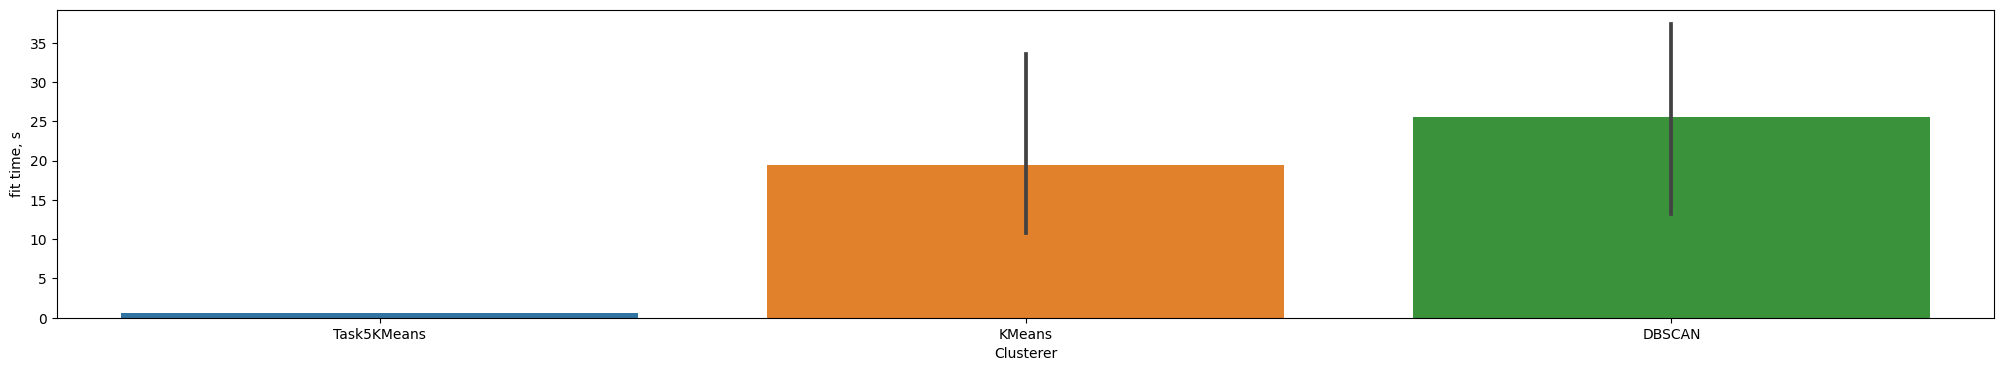

In [109]:
plt.figure(figsize=(25,4))
sns.barplot(x='Clusterer', y='fit time, s', data=results)

<Axes: xlabel='Clusterer', ylabel='Adjusted round score'>

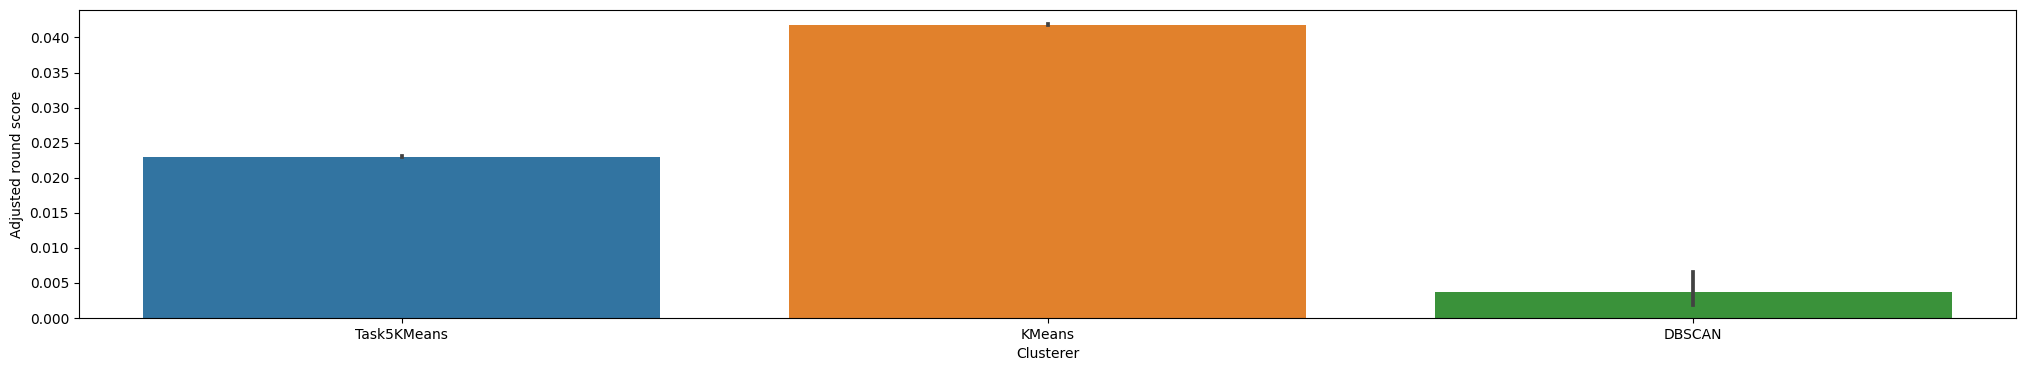

In [110]:
plt.figure(figsize=(25,4))
sns.barplot(x='Clusterer', y='Adjusted round score', data=results)

Видно, что лучший результат показал алгоритм KMeans из библиотеки sklearn. Худший же результат показал алгоритм DBSCAN. 

Тем не менее, все три алгоритма показывают низкий показатель adjusted rand score, и полученные модели кластеризуют данные совсем немного лучше, чем случайный кластеризатор. Это ожидаемо, так как данные модели принимают во внимание лишь цвета пикселей, а цвета пикселей плохо позволяют определить паттерны, которые встречаются на картинке.

Также интересно, что при 100, 200 и 300 комнонентах, оставленных с помощью PCA, результаты почти не отличаются. Однако в силу того, что качество разбиение в целом низкое тяжело сказать, что 300 компонент, оставленные с помощью PCA, являются ключевыми для кластеризации.

# Заключение

На выбранном датасете удалось обучить все три модели (самописный KMeans, sklearn KMeans и DBSCAN), и все три модели показывают результат не хуже чем случайный кластеризатор. Тем не менее, качество кластеризации довольно низкое, из чего можно сделать вывод, что выбранные алгоритмы плохо подходят для кластеризации изображений по цветам пикселей.